# Word embedding using SkipGram
The SkipGram model predicts the context using the central word.

In our implementatation, as for both the Binary SkipGram model and the CBOW model, since the batches walks are lazily generated, the memory requirements are minimal and the method can scale to very big texts.

In [1]:
import silence_tensorflow.auto # Import needed to avoid TensorFlow warnings and general useless infos.

## The parameters for this example
We are going to use as batch size $512$, the number of texts to use for each training epoch. The result embedding size, the space of the resulting vectors, is $100$. The window size is $3$, meaning the context will be formed of the four words after and before the one we are considering as the center. 

The negative samples are the number of samples to randomly extract as negatives during the NCE. We are going to use $10$ for these values. 

Relative to the early stopping mechanism, we are going to monitor the training loss, using a variation delta $0.0001$ and a patience of $50$ epochs.

In [2]:
batch_size = 128
embedding_size = 30
window_size=10
negative_samples=20
delta=0.0001
patience=20
min_counts=5

## Using NLTK
Since we are going to use NLTK, other than installing the package, don't forget to also [execute the download of the data related to the package](https://www.nltk.org/data.html), such as the stopwords:

```bash
python -m nltk.downloader all
```

NLTK is a library with *many* tools for executing NLP, that here we are not exploring in the necessary depth.

Before starting to write your custom tokenizer, please to look into NLTK and choose the tools and are useful for your use case.

## Loading the texts
Here we are going to take in consideration the Hillary emails:

In [3]:
import pandas as pd
import numpy as np
emails = pd.read_csv("../data/texts/Emails.csv")["RawText"].tolist()

## Encoding the texts

Here we use the [the Keras Tokenizer](https://keras.io/api/preprocessing/text/). This tokenizer **is NOT by any means complete** and should only be used for examples and educational porposes.

In this **very simple** tokenizer, we apply stemming using Porter stemming and drop english stop words.

For any real world application, you will also need a custom synonyms' dictionary: here we are using a general porpose synonyms dictionary that may apply or not in your own application.

In [4]:
from embiggen import CorpusTransformer

transformer = CorpusTransformer()
transformer.fit(emails, min_count=min_counts)
encoded_emails = transformer.transform(emails, min_length=window_size*2+1)

In [5]:
print(f"The transformer will use {transformer.vocabulary_size} different terms.")

The transformer will use 16064 different terms.


## Creating the training sequences
We create the training sequence:

In [6]:
from embiggen import Word2VecSequence

word2vec_sequence = Word2VecSequence(
    encoded_emails,
    batch_size=batch_size,
    window_size=window_size
)

## Creating the embedding model
Here, finally, we create the embedding model. If available, we setup the model so to run on multiple GPUs:

In [12]:
from tensorflow.distribute import MirroredStrategy
from embiggen import SkipGram
from tensorflow.keras.optimizers import Nadam

strategy = MirroredStrategy()
with strategy.scope():
    model = SkipGram(
        vocabulary_size=transformer.vocabulary_size,
        embedding_size=embedding_size,
        optimizer=Nadam(0.1),
        window_size=window_size,
        negative_samples=negative_samples,
    )

model.summary()

Model: "SkipGram"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words_embedding (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 30)        481920      words_embedding[0][0]            
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 30)           0           embedding_2[0][0]                
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 20)]         0                                            
___________________________________________________________________________________________

### Training the embedding model
Now here we execute the training of the embedding model:

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

history = model.fit(
    word2vec_sequence,
    steps_per_epoch=word2vec_sequence.steps_per_epoch,
    epochs=1000,
    callbacks=[
        EarlyStopping(
            "loss",
            min_delta=delta,
            patience=patience,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(monitor="loss", patience=patience//4)
    ]
)

Epoch 1/1000
63/63 [==============================] - 4s 70ms/step - loss: 30.7718 - lr: 0.1000
Epoch 2/1000
63/63 [==============================] - 4s 69ms/step - loss: 7.0196 - lr: 0.1000
Epoch 3/1000
63/63 [==============================] - 4s 71ms/step - loss: 6.3107 - lr: 0.1000
Epoch 4/1000
63/63 [==============================] - 4s 69ms/step - loss: 6.2308 - lr: 0.1000
Epoch 5/1000
63/63 [==============================] - 4s 69ms/step - loss: 6.1465 - lr: 0.1000
Epoch 6/1000
63/63 [==============================] - 4s 69ms/step - loss: 6.0734 - lr: 0.1000
Epoch 7/1000
63/63 [==============================] - 4s 70ms/step - loss: 6.1064 - lr: 0.1000
Epoch 8/1000
63/63 [==============================] - 4s 70ms/step - loss: 6.0308 - lr: 0.1000
Epoch 9/1000
63/63 [==============================] - 4s 69ms/step - loss: 5.9084 - lr: 0.1000
Epoch 10/1000
63/63 [==============================] - 4s 71ms/step - loss: 5.8937 - lr: 0.1000
Epoch 11/1000
63/63 [===========================

### Plotting the history
We plot the training history:

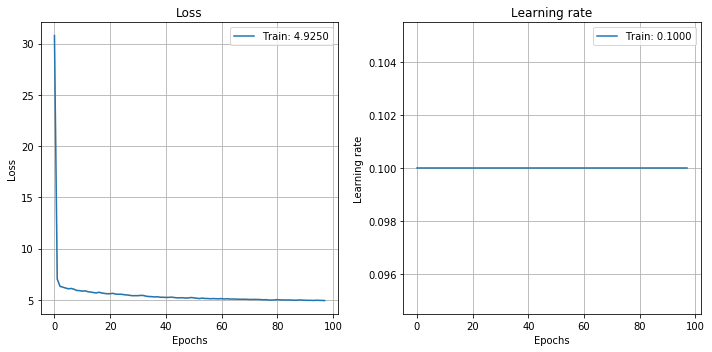

In [14]:
from plot_keras_history import plot_history
plot_history(history)

## Computing the cosine similarities

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
similarities = cosine_similarity(model.embedding)

In [26]:
word = "hillary"
similarity = similarities[transformer.get_word_id(transformer.get_synonym(word))]
transformer.reverse_transform([
    similarity.argsort()[-10:]
])

['include 3 2010 5 become 15 turn senator point hillary']

In [27]:
similarity[similarity.argsort()[-10:]]

array([0.9441921 , 0.94471127, 0.94766057, 0.9484106 , 0.94849694,
       0.9517511 , 0.9543548 , 0.957718  , 0.963446  , 1.0000001 ],
      dtype=float32)